In [2]:
# Import necessary packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift, estimate_bandwidth
import json

images = [
    'https://scentofagamer.files.wordpress.com/2020/03/trustedpegasus_chrisrahn.jpg',
    'https://images.squarespace-cdn.com/content/v1/5356aa98e4b0e10db1993391/1661208655884-5ZMSP9QUZC9ZO8QSHLD9/Fabled-Passage-Throne-of-Eldraine-MtG-Art.jpeg?format=750w',
    'https://cards.scryfall.io/art_crop/front/4/9/496849a5-4b24-4eae-8bfb-d46f645d85ea.jpg?1675200313',
    'https://www.vangoghgallery.com/img/starry_night_full.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/1200px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg',
    'https://d.newsweek.com/en/full/822411/pikachu-640x360-pokemon-anime.jpg?w=1600&h=1200&q=88&f=3ed1c0d6e3890cbc58be90f05908a8f5'
]


In [4]:
def input_img(path):
    image = tf.image.decode_png(tf.io.read_file(path))
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224,224])
    return image

def normalize_image(img):
    grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm

def convolution(img, kernel):
    # img has shape (x, y), already normalized
    # kernel has shape (3, 3)
    # output has shape (x-2, y-2)
    x = img.shape[0]
    y = img.shape[1]
    output = np.zeros((x-2, y-2))
    for i in range(1, x-1):
        for j in range(1, y-1):
            output[i-1, j-1] = np.sum(img[i-1:i+2, j-1:j+2] * kernel)
    return output

def blur(img):
    # img has shape (x, y), already normalized
    
    # gaussian filter
    kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
    img = convolution(img, kernel)
    img = convolution(img, kernel)

    # normalize
    img = (img - np.min(img))/ (np.max(img)- np.min(img))

    return img

def turbulence(img):
    # img has shape (x, y), already normalized
    # kernel has shape (5, 5)
    # output has shape (x-2, y-2)
    x = img.shape[0]
    y = img.shape[1]
    output = np.zeros((x-4, y-4))
    for i in range(2, x-2):
        for j in range(2, y-2):
            output[i-2, j-2] = np.max(img[i-2:i+3, j-2:j+3]) - np.min(img[i-2:i+3, j-2:j+3])
    return output

def quinticBezier(x):
    return 6*x**5 - 15*x**4 + 10*x**3

def polarize(img):
    # img has shape (x, y)

    img = turbulence(img)

    # mean
    mean = np.mean(img)
    stddev = np.std(img)

    # mean should be 0.5, stddev should be 0.1
    img = (img - mean) / stddev
    img = 1 / (1 + np.exp(-img))

    img = blur(img)

    img = (img - np.min(img))/ (np.max(img)- np.min(img))

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i, j] = quinticBezier(img[i, j])

    return img
    
def segment(img):
    resolution_ratio = 0.1
    cutoff = .5

    # img has shape (x, y)
    # output has shape (Math.ceil(x*resolution_ratio), Math.ceil(y*resolution_ratio))

    x = img.shape[0]
    y = img.shape[1]

    output = np.zeros((int(np.ceil(x*resolution_ratio)), int(np.ceil(y*resolution_ratio))))

    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            output[i, j] = np.mean(img[int(i/resolution_ratio):int((i+1)/resolution_ratio), int(j/resolution_ratio):int((j+1)/resolution_ratio)])
            

    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            if output[i, j] < cutoff:
                output[i, j] = 0
            else:
                output[i, j] = 1

    return output

def plot_images(img1, img2, img3, img4):
    fig, axs = plt.subplots(1, 4, figsize=(15, 15))
    axs[0].imshow(img1)
    axs[1].imshow(img2, cmap = "hot")
    axs[2].imshow(img3, cmap = "hot")
    axs[3].imshow(img4, cmap = "seismic")
    plt.show()

def get_salient_region(src_img, test_model):
    img = tf.keras.applications.densenet.preprocess_input(src_img)

    result = test_model(img)
    max_idx = tf.argmax(result, axis = 1)

    with tf.GradientTape() as tape:
        tape.watch(img)
        result = test_model(img)
        max_score = result[0, max_idx[0]]
    return tape.gradient(max_score, img)

def show_saliency(image_url, test_model):
    filename = 'image.jpg'
    print(image_url)
    urllib.request.urlretrieve(image_url, filename)
    src_img = cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2RGB)
    # resize to 224, 224
    src_img = cv.resize(src_img, (224, 224))

    img = input_img(filename)
    grads = get_salient_region(img, test_model)
    
    plot_images(src_img, normalize_image(grads[0]), blur(normalize_image(grads[0])), polarize(blur(normalize_image(grads[0]))))

test_model = tf.keras.applications.resnet50.ResNet50()

for image in images:
    show_saliency(image, test_model)


https://scentofagamer.files.wordpress.com/2020/03/trustedpegasus_chrisrahn.jpg


KeyboardInterrupt: 

Number of segments:  7


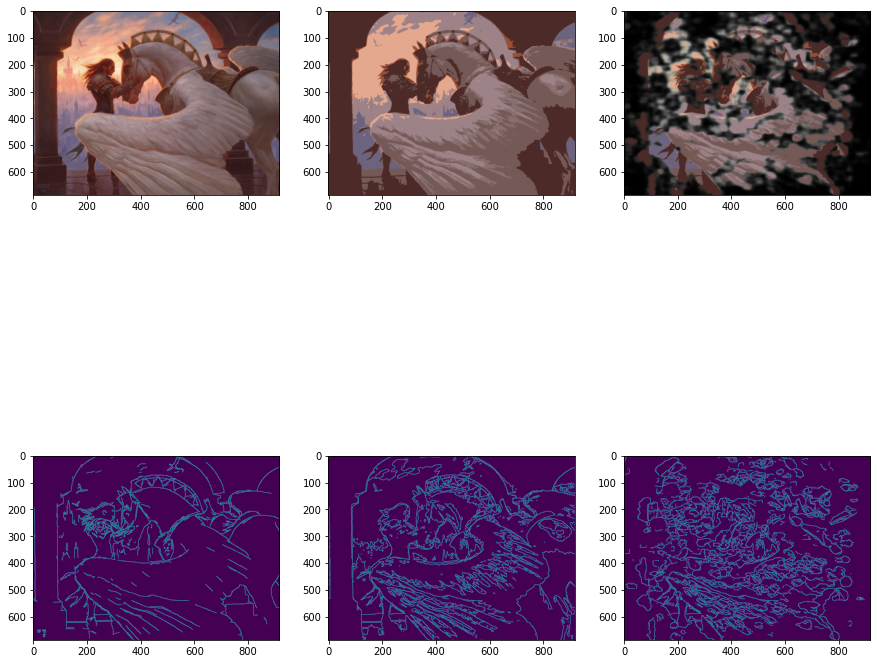

Number of segments:  16


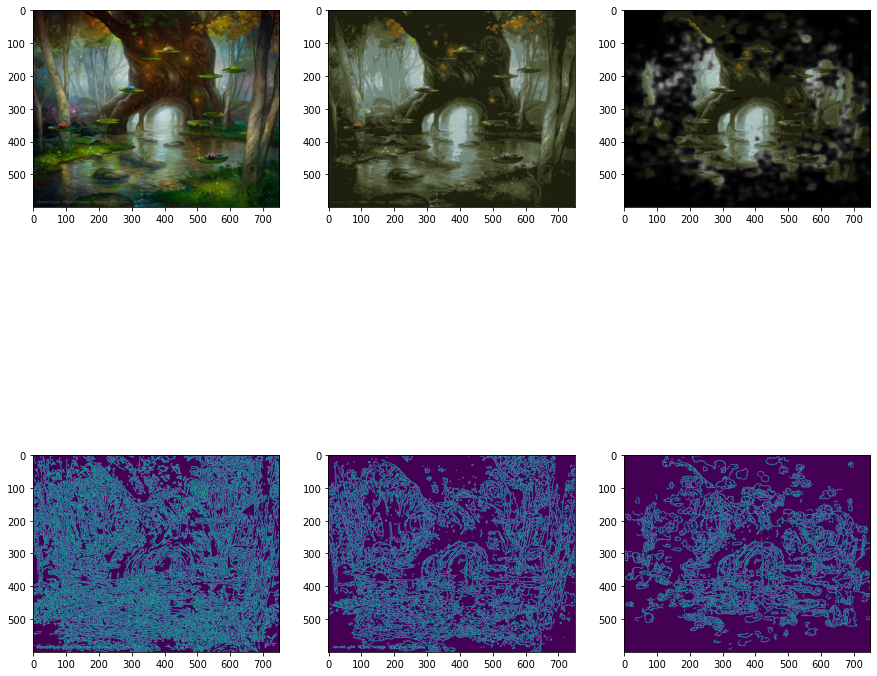

Number of segments:  14


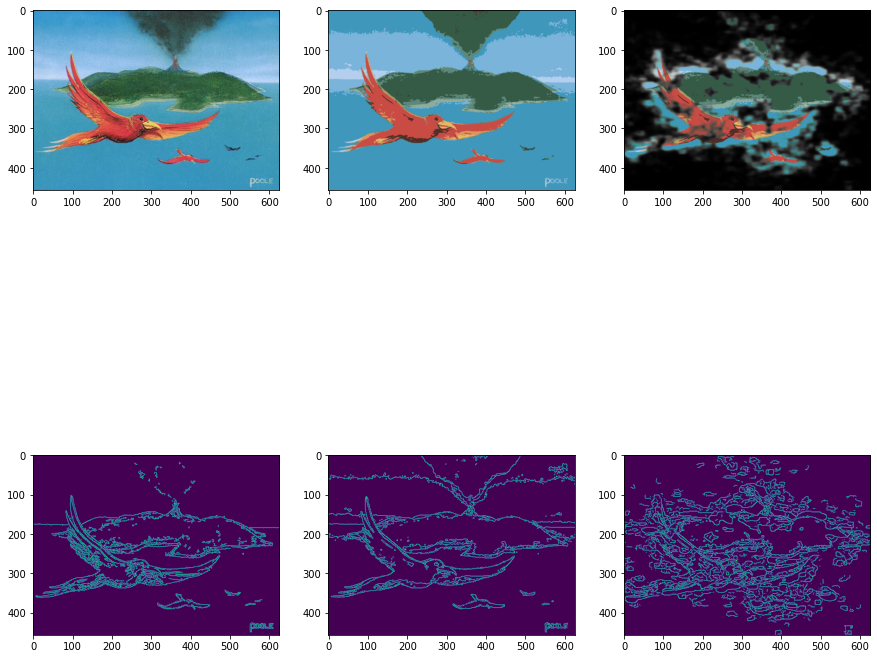

Number of segments:  5


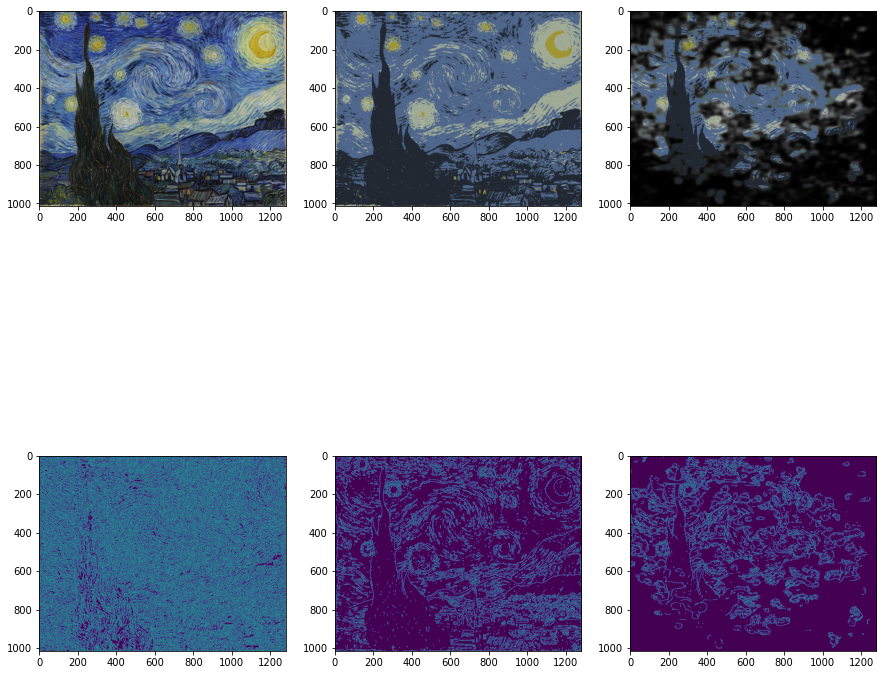

Number of segments:  14


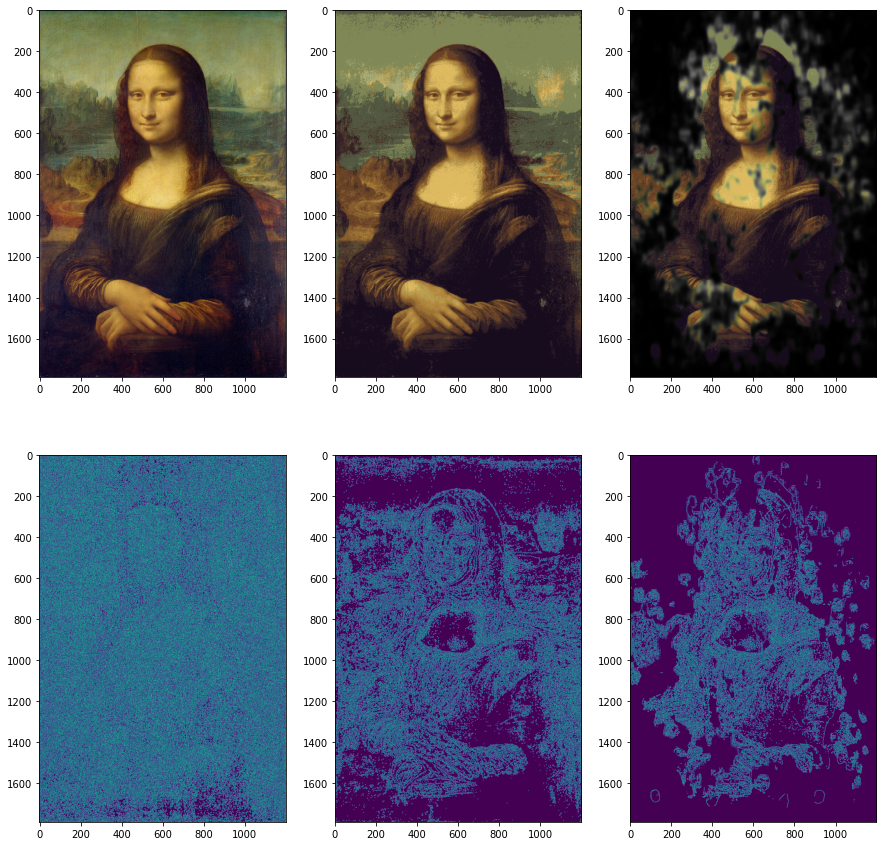

Number of segments:  26


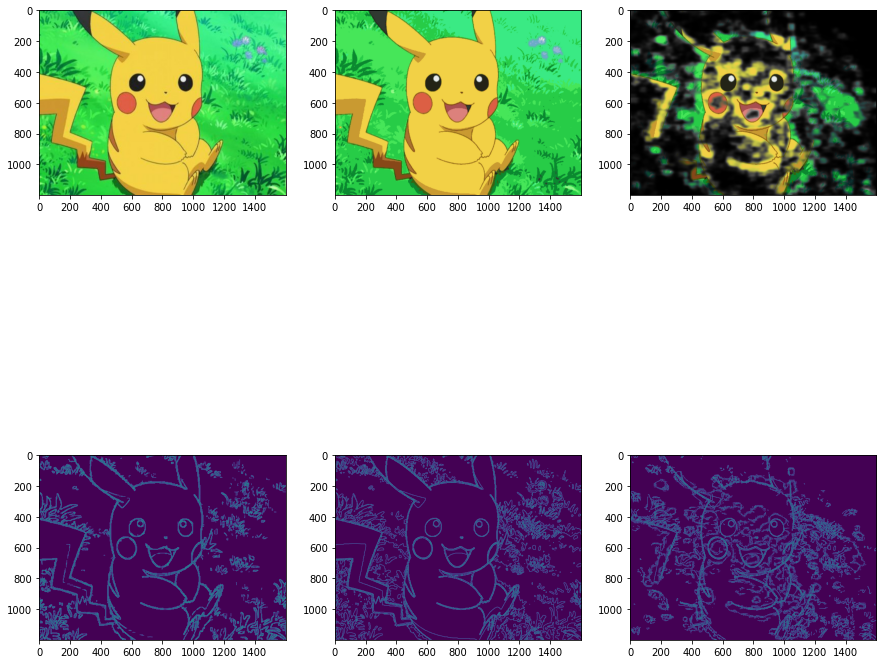

In [4]:
def plot_images(img1, img2, img3, img4, img5, img6):
  fig, axs = plt.subplots(2, 3, figsize=(15, 15))
  axs[0, 0].imshow(img1)
  axs[0, 1].imshow(img2)
  axs[0, 2].imshow(img3)
  axs[1, 0].imshow(img4)
  axs[1, 1].imshow(img5)
  axs[1, 2].imshow(img6)
  plt.show()

def edges(img, sigma):
  median = np.median(img)
  lower = int(max(0, (1.0 - sigma) * median))
  upper = int(min(255, (1.0 + sigma) * median))
  return cv.Canny(img, lower, upper)

def mask_with_salient_region(img, grads):
  saliency = np.uint8(grads*255)

  # resive to dim of img
  saliency = cv.resize(saliency, (img.shape[1], img.shape[0]))

  # saliency is just a 2d array, convert to 3 channel rgb
  saliency = [saliency, saliency, saliency]
  saliency = np.transpose(saliency, (1, 2, 0))

  # mask the image
  return np.minimum(img, saliency)

def meanshift(image_url, test_model):
  filename = 'image.jpg'
  urllib.request.urlretrieve(image_url, filename)
  img = cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2RGB)
  src_img = cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2RGB)

  # filter to reduce noise
  img = cv.medianBlur(img, 3)

  # flatten the image
  flat_image = img.reshape((-1,3))
  flat_image = np.float32(flat_image)

  # meanshift
  bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)
  ms = MeanShift(bandwidth=bandwidth, max_iter=100, bin_seeding=True)
  ms.fit(flat_image)
  labeled=ms.labels_

  # get number of segments
  segments = np.unique(labeled)
  print('Number of segments: ', segments.shape[0])

  # get the average color of each segment
  total = np.zeros((segments.shape[0], 3), dtype=float)
  count = np.zeros(total.shape, dtype=float)
  for i, label in enumerate(labeled):
    total[label] = total[label] + flat_image[i]
    count[label] += 1
  avg = total/count
  avg = np.uint8(avg)
  
  # cast the labeled image into the corresponding average color
  res = avg[labeled]
  result = res.reshape((img.shape))

  img_tf = input_img(filename)
  grads = get_salient_region(img_tf, test_model)
  saliency = polarize(blur(normalize_image(grads[0])))
  
  # mask the image
  masked = mask_with_salient_region(result, saliency)

  edges_src = edges(src_img, .33)
  edges_res = edges(result, .33)
  edges_masked = edges(masked, .33)

  plot_images(src_img, result, masked, edges_src, edges_res, edges_masked)
  
test_model = tf.keras.applications.resnet50.ResNet50()

for image in images:
    meanshift(image, test_model)


In [5]:
test_model = tf.keras.applications.resnet50.ResNet50()

def colorQuant(img, Z, K, criteria):

   ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
   
   # Now convert back into uint8, and make original image
   center = np.uint8(center)
   res = center[label.flatten()]
   res2 = res.reshape((img.shape))
   return res2

def plot_images(img1, img2, img3, img4, img5):
   fig, axs = plt.subplots(1, 5, figsize=(15, 15))
   axs[0].imshow(img1)
   axs[1].imshow(img2)
   axs[2].imshow(img3)
   axs[3].imshow(img4)
   axs[4].imshow(img5)
   plt.show()

def draw_contours(src, img):
   img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
   ret, im = cv.threshold(img_gray, 100, 255, cv.THRESH_BINARY_INV)
   contours, hierarchy  = cv.findContours(im, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
   # vibrant pink
   color = (255, 0, 255)
   return cv.drawContours(src, contours, -1, color, 2)

def process(image, test_model):

   k_values = [2, 3, 4, 5]
   
   filename = 'image.jpg'
   urllib.request.urlretrieve(image, filename)

   img_tf = input_img(filename)
   grads = get_salient_region(img_tf, test_model)
   saliency = polarize(blur(normalize_image(grads[0])))

   for value in k_values:
      img = cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2RGB)
      
      # add guassian blur
      blurred = cv.GaussianBlur(img, (5, 5), 0)
      # again
      blurred = cv.GaussianBlur(blurred, (5, 5), 0)

      meanshifted = colorQuant(blurred, np.float32(blurred.reshape((-1,3))), value, (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0))

      # create new image with zeros
      empty = np.zeros(img.shape, dtype=np.uint8)

      src_img = cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2RGB)
      contours_src = draw_contours(src_img, meanshifted)
      contours_saliency = draw_contours(empty, meanshifted)

      # mask contours_saliency with saliency
      contours_saliency_masked = mask_with_salient_region(contours_saliency, saliency)

      plot_images(img, meanshifted, contours_src, contours_saliency, contours_saliency_masked)
      

for image in images:
    process(image, test_model)


KeyboardInterrupt: 

[[ 79.09554   46.01382   43.643055]
 [127.33854  101.23796  102.151   ]
 [192.38014  149.37093  139.00531 ]]


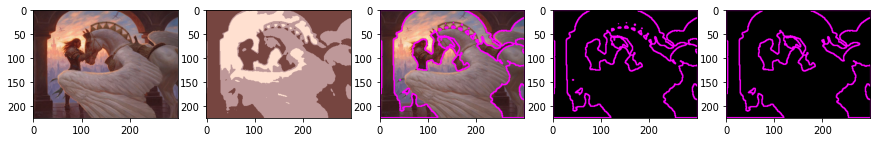

[[ 40.205723  42.236477  22.027485]
 [ 83.5       88.84878   57.331062]
 [125.59252  145.31836  131.88448 ]]


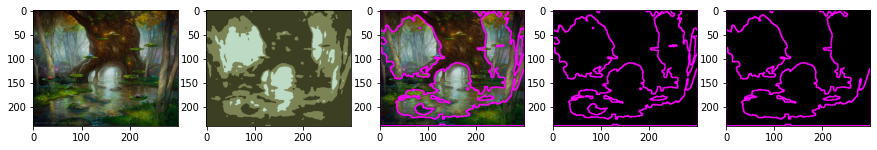

[[ 58.5466    95.55355   76.79806 ]
 [ 84.60309  161.24883  195.3432  ]
 [189.66777   94.083885  80.201294]]


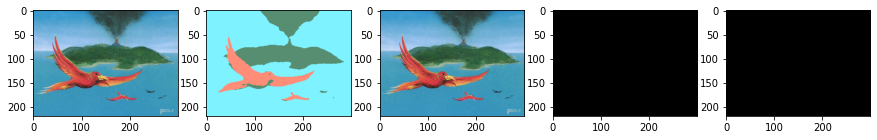

[[ 40.048225  46.576767  54.48917 ]
 [ 71.401184  93.54611  133.06726 ]
 [131.31491  147.57613  142.94716 ]]


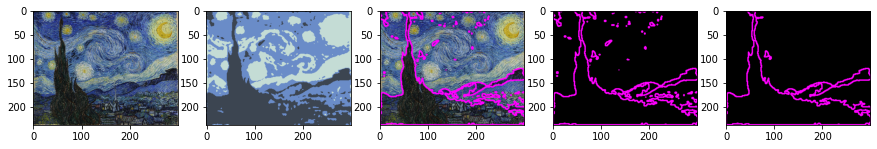

[[ 38.67856   24.742596  36.441315]
 [ 97.741325  83.207344  54.672997]
 [157.1082   146.00935   84.42024 ]]


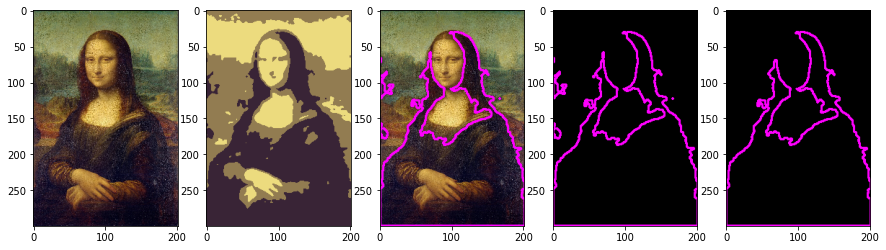

[[ 52.15841  132.56609   52.573544]
 [ 53.519623 216.52762   92.070244]
 [230.19296  194.90388   67.24808 ]]


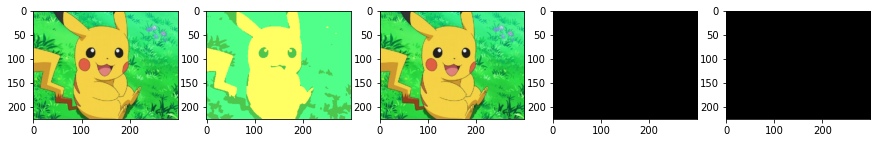

In [14]:
test_model = tf.keras.applications.resnet50.ResNet50()

def colorQuant(img, Z, K, criteria):

   ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
   
   unique_colors = np.unique(center, axis=0)

   # Now convert back into uint8, and make original image
   center = np.uint8(center)
   res = center[label.flatten()]
   res2 = res.reshape((img.shape))
   return res2, unique_colors

def plot_images(img1, img2, img3, img4, img5):
   fig, axs = plt.subplots(1, 5, figsize=(15, 15))
   axs[0].imshow(img1)
   axs[1].imshow(img2)
   axs[2].imshow(img3)
   axs[3].imshow(img4)
   axs[4].imshow(img5)
   plt.show()

def get_contours(img):
   img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
   ret, im = cv.threshold(img_gray, 100, 255, cv.THRESH_BINARY_INV)
   contours, hierarchy  = cv.findContours(im, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
   return contours

def neccessary_score(length):   
   return max(.1, 10.0 / length)


def get_masked_contours(img, saliency):
   # resize saliency to img, in case we ran a filter kernel on it and it changed size
   saliency = cv.resize(saliency, (img.shape[1], img.shape[0]))

   contours = get_contours(img)
   # we now have a list of contours
   # we want to mask each contour with saliency
   masked = []

   for contour in contours:
      # calculate the mean saliency of the contour
      mean = np.mean(saliency[contour[:, :, 1], contour[:, :, 0]])

      # if the mean is above the threshold, add it to the list
      if mean > neccessary_score(len(contour)):
         masked.append(contour)

   return masked


def draw_contours(src, contours):
   # vibrant pink
   color = (255, 0, 255)
   return cv.drawContours(src, contours, -1, color, 2)


def resize_to_max(img, max_dim):
   # resize such that the larger dim is max_dim
   if img.shape[0] > img.shape[1]:
      img = cv.resize(img, (int(img.shape[1] * max_dim / img.shape[0]), max_dim))
   else:
      img = cv.resize(img, (max_dim, int(img.shape[0] * max_dim / img.shape[1])))
   return img

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


def save_pegs(img_src, contours, colors, img_width, img_height, filename):
   # calculates where to place block pegs and saves in json
   peg_length = 15
   pegs = []

   for contour in contours:

      # if the segments are too large, we need to add midpoints
      
      for i in range(1, len(contour)):
         point = contour[i, 0]
         prev = contour[i-1, 0]
         dist = np.linalg.norm(point - prev)

         if dist > 1.5 * peg_length:
            num_pegs = int(dist / peg_length)
            for j in range(1, num_pegs):
               # insert new points into the contour
               new_point = prev + (point - prev) * (j / num_pegs)
               contour = np.insert(contour, i + j - 1, new_point, axis=0)



      start = contour[0, 0]

      for i in range(1, len(contour)):
         point = contour[i, 0]
         dist = np.linalg.norm(point - start)

         if dist > peg_length:
            pegs.append(np.array([[start[0]/img_width, start[1]/img_height], [point[0]/img_width, point[1]/img_height]]))
            start = point

   # save to json
   result = {
      'filename': img_src,
      'pegs': pegs,
      'palette': np.array(colors)
   }

   with open(filename, 'w') as outfile:
      json.dump(result, outfile, cls=NumpyEncoder)



def process(image, test_model, save_filename):   
   filename = 'image.jpg'
   urllib.request.urlretrieve(image, filename)

   img_tf = input_img(filename)
   grads = get_salient_region(img_tf, test_model)
   saliency = polarize(blur(normalize_image(grads[0])))

   img = cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2RGB)   


   # resize such that the larger dim is 200
   img = resize_to_max(img, 300)

   # add guassian blur
   blurred = cv.GaussianBlur(img, (5, 5), 0)
   blurred = cv.GaussianBlur(blurred, (5, 5), 0)

   meanshifted, colors = colorQuant(blurred, np.float32(blurred.reshape((-1,3))), 3, (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0))

   print(colors)

   # increase contrast of meanshifted
   alpha = 1.5 # Contrast control (1.0-3.0)
   beta = 0 # Brightness control (0-100)
   meanshifted = cv.convertScaleAbs(meanshifted, alpha=alpha, beta=beta)
   

   src_img = cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2RGB)
   src_img = resize_to_max(src_img, 300)
   contours_src = draw_contours(src_img, get_contours(meanshifted))
   contours_saliency = draw_contours(np.zeros(img.shape, dtype=np.uint8), get_contours(meanshifted,))
   contours_saliency_masked = draw_contours(np.zeros(img.shape, dtype=np.uint8), get_masked_contours(meanshifted, saliency))

   plot_images(img, meanshifted, contours_src, contours_saliency, contours_saliency_masked)

   save_pegs(image, get_masked_contours(meanshifted, saliency), colors, meanshifted.shape[1], meanshifted.shape[0], save_filename)
      
# enumerate
for image, i in zip(images, range(len(images))):
    process(image, test_model, 'output/peg' + str(i) + '.peggle')
